In [1]:
# import jax.numpy as np
# import numpy as tnp
from prysm.mathops import np,fft
import matplotlib.pyplot as plt
import prysm
prysm.__version__

'0.19.2.dev422+gfb77e89'

In [2]:
# SIMULATION PARAMETERS
EFL = 131.4e3 # milimeters
EPD = 6.510e3 # milimeters
WVL = 0.656   # microns
OS = 6
IMG_NPIX = 1024

# Dark Hole
IWA = 3
OWA = 5
AZMIN = -180
AZMAX = 180

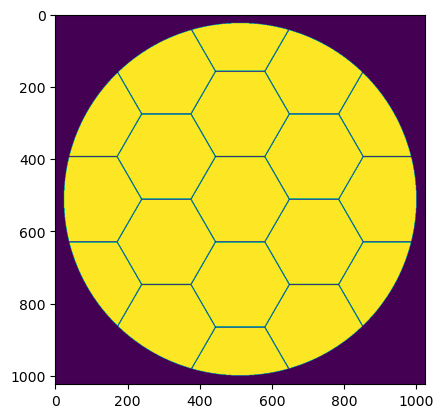

In [4]:
from astropy.io import fits

# Load Aperture
circle_mask = fits.getdata('/Users/jashcraft/Downloads/hex_pupil_amplitude_6510mm_1024pix.fits')
plt.imshow(circle_mask)
PUPIL_NPIX = circle_mask.shape[0]

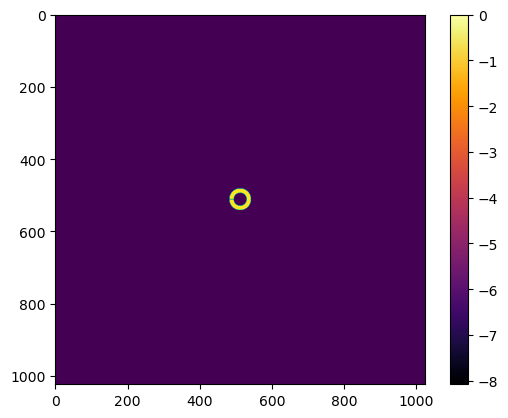

In [6]:
from prysm.propagation import focus_fixed_sampling,focus_fixed_sampling_backprop
from prysm import coordinates, geometry

img_dx = WVL * (EFL / EPD) / OS
pupil_dx = EPD / PUPIL_NPIX
# now set up the focal plane mask
psf = focus_fixed_sampling(wavefunction=circle_mask,
                           input_dx=pupil_dx,
                           prop_dist=EFL,
                           wavelength=WVL,
                           output_dx=img_dx,
                           output_samples=IMG_NPIX)

from dygdug.models import ImgSamplingSpec, one_sided_annulus

lambd = EFL / EPD * WVL  # um
iss = ImgSamplingSpec(IMG_NPIX, lambd / OS, lambd)  # 10/lambd
dh = one_sided_annulus(iss, IWA,
                            OWA, 
                            AZMIN,
                            AZMAX)
psf_I = np.abs(psf)**2
plt.imshow(dh * np.log10(psf_I/psf_I.max()+1e-16),cmap='inferno')
plt.colorbar()

# create the core mask
def inner_core_mask(iss, iwa):

    x, y = coordinates.make_xy_grid(iss.N, dx=iss.dx)
    r, t = coordinates.cart_to_polar(x, y)
    iwa = iwa * iss.lamD
    mask = geometry.circle(iwa, r)

    return mask

def knife_edge_mask(iss, iwa):
    x, y = coordinates.make_xy_grid(iss.N, dx=iss.dx)
    iwa = iwa * iss.lamD
    mask = x > iwa

    return mask

def lyot_mask(pupil_npix, pupil_dx, frac):

    x, y = coordinates.make_xy_grid(pupil_npix, dx=pupil_dx)
    r, t = coordinates.cart_to_polar(x, y)
    rnorm = r / (r.max() * np.sqrt(2))
    ls = np.zeros_like(x)
    ls[rnorm < frac/2] = 1

    return ls


# mask transmits inner 1.5 L/D
inner_mask = inner_core_mask(iss, 1.5)
knife_mask = knife_edge_mask(iss, IWA)
ls_mask = lyot_mask(circle_mask.shape[0], pupil_dx=pupil_dx, frac=0.85)
plt.imshow(dh)

In [7]:
# config vapp optimizer
from dygdug.vappid import VAPPOptimizer2,AAPOptimizer2

vapp = VAPPOptimizer2(amp=circle_mask,
                      amp_dx=pupil_dx,
                      efl=EFL, 
                      wvl=WVL, 
                      basis=None, 
                      dark_hole=dh,
                      dh_target=1e-15,
                      dh_dx=img_dx)

vapp.set_optimization_method(zonal=True)
print(vapp.zonal)
vapp.fwd(np.zeros(vapp.amp[vapp.amp_select].shape))

aplc = AAPOptimizer2(amp=circle_mask,
                      amp_dx=pupil_dx,
                      efl=EFL, 
                      wvl=WVL, 
                      basis=None, 
                      dark_hole=dh,
                      dh_target=1e-15,
                      dh_dx=img_dx)

aplc.set_optimization_method(zonal=True)
print(aplc.zonal)
aplc.fwd(np.random.random(aplc.amp[aplc.amp_select].shape))

True
True


22904.135563269832

In [8]:
from prysm.x.optym import F77LBFGSB

In [9]:
# !PLAY WITH ME
# x0 = np.zeros(vapp.amp.shape, dtype=float)[vapp.amp_select]
# x0 = np.ascontiguousarray(x0)
# opt = F77LBFGSB(vapp.fg, x0, memory=10)
# opt.iprint = 0
# for _ in range(200):
#     opt.step()

x0 = np.ones(aplc.amp.shape, dtype=float)[aplc.amp_select]
x0 = np.ascontiguousarray(x0)
opt = F77LBFGSB(aplc.fg, x0, memory=10, upper_bounds=np.ones(x0.shape), lower_bounds=np.zeros(x0.shape))
opt.iprint = 0
for _ in range(100):
    opt.step()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       732197     M =           10


/var/folders/xs/d1q2b9xj0j35ml7lb2vmfb240000gn/T/ipykernel_93171/1944617699.py:4: RuntimeWarning: invalid value encountered in divide
  plt.imshow(np.imag(aplc.gbar * aplc.g.conj())/aplc.amp,cmap='RdBu_r')


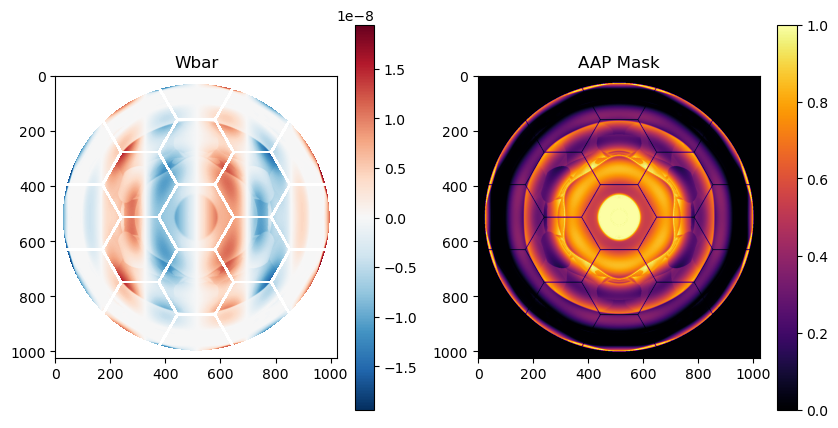

In [13]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.title('Wbar')
plt.imshow(np.imag(aplc.gbar * aplc.g.conj())/aplc.amp,cmap='RdBu_r')
plt.colorbar()
plt.subplot(122)
plt.title('AAP Mask')
plt.imshow(aplc.aap,cmap='inferno')
plt.colorbar()
plt.show()

In [19]:
U,S,Vt  = np.linalg.svd(aplc.I)

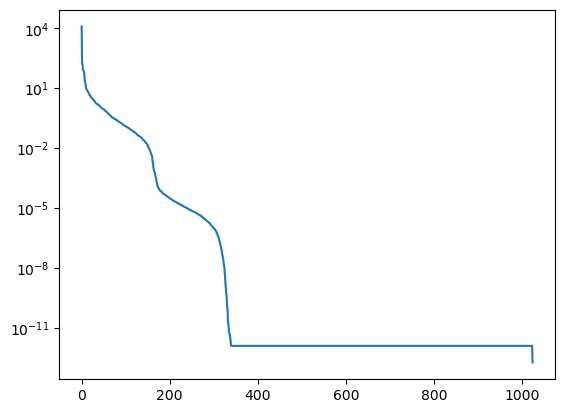

In [20]:
plt.plot(S)
plt.yscale('log')

In [21]:
np.sum(aplc.aap)/np.sum(circle_mask)

0.3878561759763182

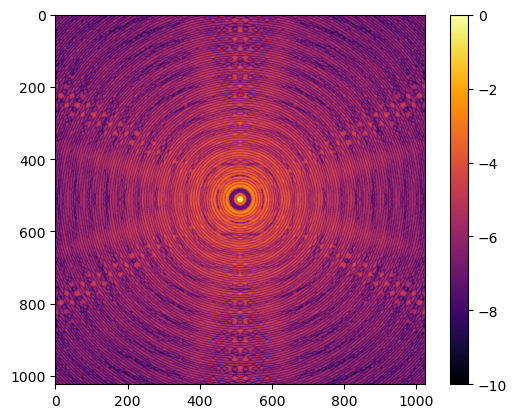

In [22]:
plt.imshow(np.log10(aplc.I/aplc.I.max()),cmap='inferno',vmin=-10)
plt.colorbar()

In [23]:
help(F77LBFGSB)

Help on class F77LBFGSB in module prysm.x.optym.optimizers:

class F77LBFGSB(builtins.object)
 |  F77LBFGSB(fg, x0, memory=10, lower_bounds=None, upper_bounds=None)
 |  
 |  Limited Memory Broyden Fletcher Goldfarb Shannon optimizer, variant B (L-BFGS-B).
 |  
 |  L-BFGS-B is a Quasi-Newton method which uses the previous m gradient vectors
 |  to perform the BFGS update, which itself is an approximation of Newton's
 |  Method.
 |  
 |  The "L" in L-BFGS is Limited Memory, due to this m*n storage requirement,
 |  where m is a small integer (say 10 to 30), and n is the number of variables.
 |  
 |  At its core, L-BFGS solves the BFGS update using an adaptive line search,
 |  satisfying the strong Wolfe conditions, which guarantee that it does not
 |  move uphill.
 |  
 |  Variant B (BFGS-B) incorporates subspace minimization, which further
 |  accelerates convergence.
 |  
 |  Subspace minimization is the practice of forming a lower-dimensional "manifold"
 |  (essentially, enclosing Eucl

In [30]:
from prysm.propagation import unfocus_fixed_sampling
psf = focus_fixed_sampling(wavefunction=aplc.aap,
                           input_dx=pupil_dx,
                           prop_dist=EFL,
                           wavelength=WVL,
                           output_dx=img_dx,
                           output_samples=IMG_NPIX)

lyot = unfocus_fixed_sampling(wavefunction=psf * knife_mask,
                              input_dx=img_dx,
                              prop_dist=EFL,
                              wavelength=WVL,
                              output_dx=pupil_dx,
                              output_samples=PUPIL_NPIX)

coro = focus_fixed_sampling(wavefunction=lyot * ls_mask,
                           input_dx=pupil_dx,
                           prop_dist=EFL,
                           wavelength=WVL,
                           output_dx=img_dx,
                           output_samples=IMG_NPIX)

/var/folders/xs/d1q2b9xj0j35ml7lb2vmfb240000gn/T/ipykernel_93171/1419866157.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(psf*knife_mask)**2),vmin=-10)


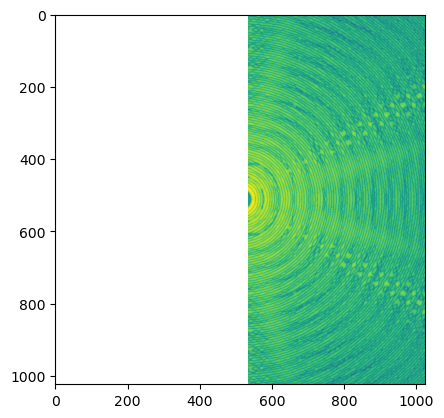

In [31]:
plt.imshow(np.log10(np.abs(psf*knife_mask)**2),vmin=-10)

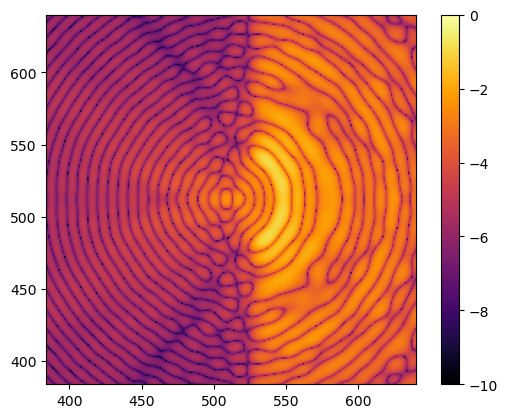

In [32]:
cut = 128
plt.imshow(np.log10(np.abs(coro)**2 / aplc.I.max()),vmin=-10,vmax=0,cmap='inferno')

# for focal plane
plt.xlim(IMG_NPIX/2 - cut, IMG_NPIX/2 + cut)
plt.ylim(IMG_NPIX/2 - cut, IMG_NPIX/2 + cut)
plt.colorbar()

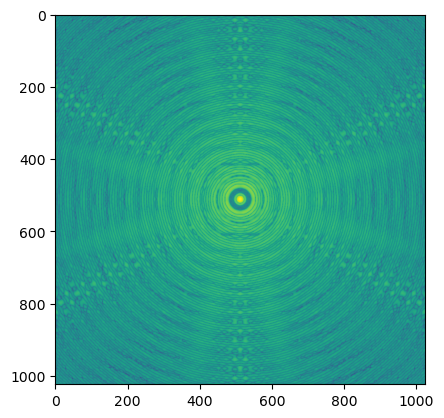

In [33]:
plt.imshow(np.log10(aplc.I))

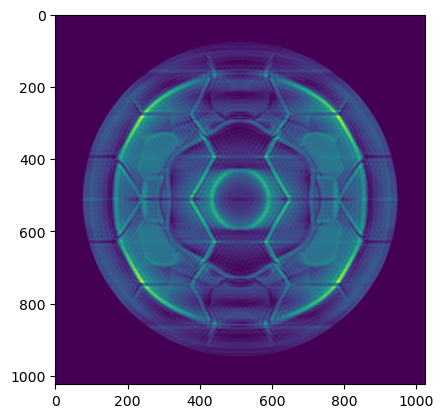

In [34]:
plt.imshow(np.abs(lyot)*ls_mask)